In [100]:
import xml.etree.ElementTree as ET
import os
from PIL import Image
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import glob
import random
import numpy as np
import seaborn as sns
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Activation, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from livelossplot import PlotLossesKeras
from sklearn.metrics import classification_report, confusion_matrix

In [55]:
annot_path = '/kaggle/input/blood-cells/dataset-master/dataset-master/Annotations'
img_path = '/kaggle/input/blood-cells/dataset-master/dataset-master/JPEGImages'

In [56]:
label = pd.read_csv('/kaggle/input/blood-cells/dataset-master/dataset-master/labels.csv')

In [57]:
label['Category']=label.drop('Unnamed: 0', axis=1)['Category'].apply(lambda x: x if x in ['NEUTROPHIL', 'EOSINOPHIL', 'LYMPHOCYTE', 'LYMPHOCYTE', 'MONOCYTE'] else 'other')

In [58]:
label

,Unnamed: 0,Image,Category
0,NaN,0,NEUTROPHIL
1,NaN,1,NEUTROPHIL
2,NaN,2,NEUTROPHIL
3,NaN,3,NEUTROPHIL
4,NaN,4,NEUTROPHIL
...,...,...,...
406,NaN,406,other
407,NaN,407,NEUTROPHIL
408,NaN,408,NEUTROPHIL
409,NaN,409,NEUTROPHIL


In [59]:
label['Category'].value_counts().reset_index()

,index,Category
0,NEUTROPHIL,207
1,EOSINOPHIL,88
2,other,62
3,LYMPHOCYTE,33
4,MONOCYTE,21


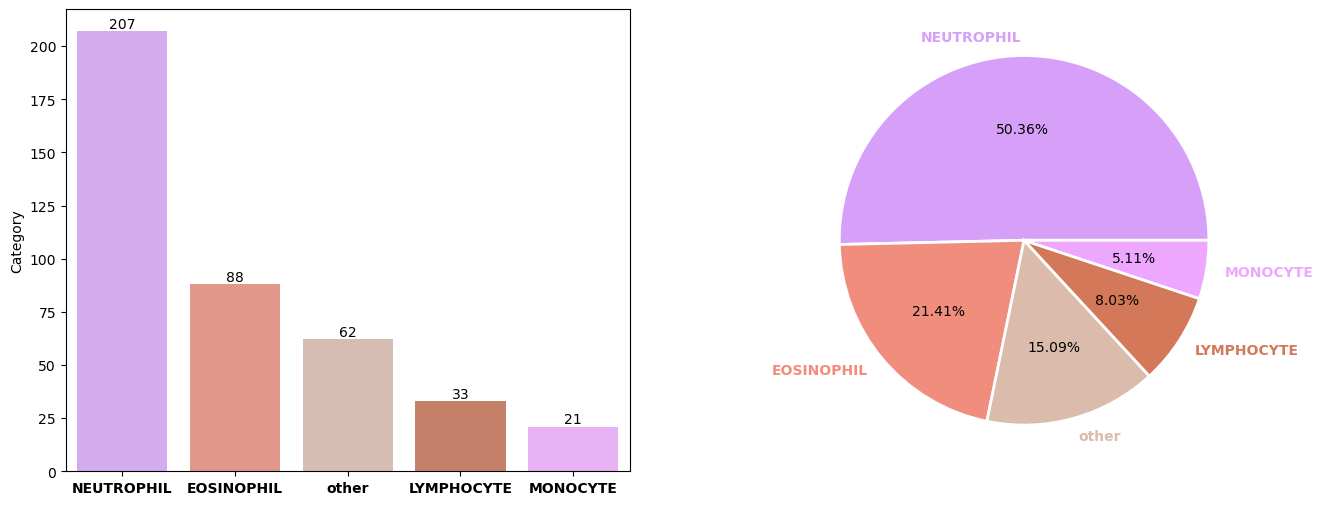

In [60]:
color = ['#' + ''.join([random.choice('0123456789ABCDEF') for i in range(6)]) for i in range(label['Category'].nunique())]
fig, axes = plt.subplots(1,2, figsize=(16,6))
sns.barplot(data=label['Category'].value_counts().reset_index(), x='index', y='Category',palette=color ,ax=axes[0])
for i in axes[0].containers:
    axes[0].bar_label(i)
axes[0].set_xlabel('')
for l in axes[0].get_xticklabels():
    l.set_fontsize(10)
    l.set_weight('semibold')

paches, text, pts = axes[1].pie(label['Category'].value_counts().reset_index()['Category'], 
                                labels=label['Category'].value_counts().reset_index()['index'],
                                autopct='%1.2f%%', 
                                wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
                                textprops={'size': 'x-large'}, colors=color)

for i in text:
    i.set_fontsize(10)
    i.set_weight('semibold')
for num, i in enumerate(paches):
    text[num].set_color(i.get_facecolor())
for i in pts:
    i.set_fontsize(10)

## take a look at one example

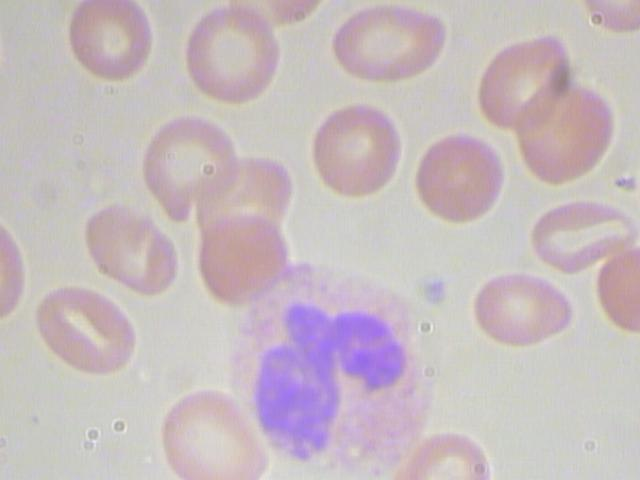

In [61]:
Image.open(os.path.join(img_path, os.listdir(img_path)[88]))

In [62]:
dataset= {'Filename':[], 'Category':[], 'Width':[], 'Height':[], 'xmin':[], 'ymin':[], 'xmax':[], 'ymax':[]}

In [63]:
for annot in glob.glob(annot_path +'/*.xml'):
    tree = ET.parse(annot)
    for element in tree.iter():
        if 'size' in element.tag:
            for attributes in list(element):
                if 'width' in attributes.tag:
                    width = int(round(float(attributes.text)))
                if 'height' in attributes.tag:
                    height = int(round(float(attributes.text)))
        if 'object' in element.tag:
            for attributes in list(element):
                if 'name' in attributes.tag:
                    name = attributes.text
                    dataset['Category']+=[name]
                    dataset['Width']+= [width]
                    dataset['Height']+= [height]
                    dataset['Filename']+= [annot.split('/')[-1][0:-4]+'.jpg']

                if 'bndbox' in attributes.tag:
                    for dimension in list(attributes):
                        if 'xmin' in dimension.tag:
                            xmin = int(round(float(dimension.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dimension.tag:
                            ymin = int(round(float(dimension.text)))
                            dataset['ymin']+=[ymin]
                        if 'xmax' in dimension.tag:
                            xmax = int(round(float(dimension.text)))
                            dataset['xmax']+=[xmax]
                        if 'ymax' in dimension.tag:
                            ymax = int(round(float(dimension.text)))
                            dataset['ymax']+=[ymax]

In [64]:
df = pd.DataFrame(dataset)

In [65]:
img = cv2.imread(os.path.join(img_path, os.listdir(img_path)[88]))
for index, row in df[df['Filename']==os.listdir(img_path)[88]].iterrows():
    cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (255, 0, 0), 1)
    cv2.putText(img, row['Category'],(row['xmin'], row['ymin']+20), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 1,8)

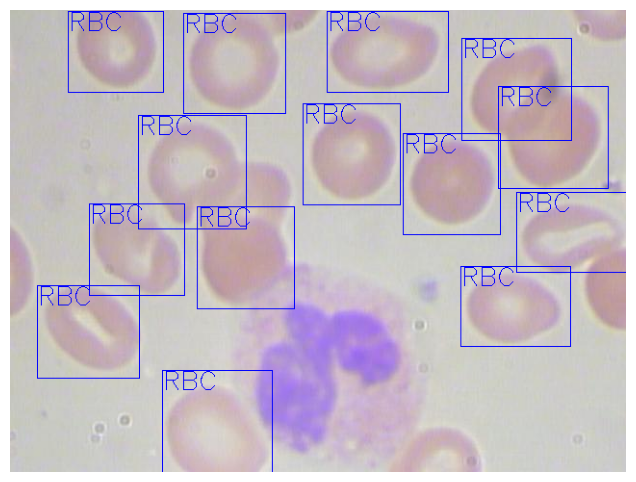

In [66]:
plt.imshow(img[:,:,::-1]) # the annotation only locate the rbc not the wbc
fig = plt.gcf()
fig.set_size_inches(10,6)
plt.axis('off');

### visualize the images by classes

In [67]:
Train_path = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'

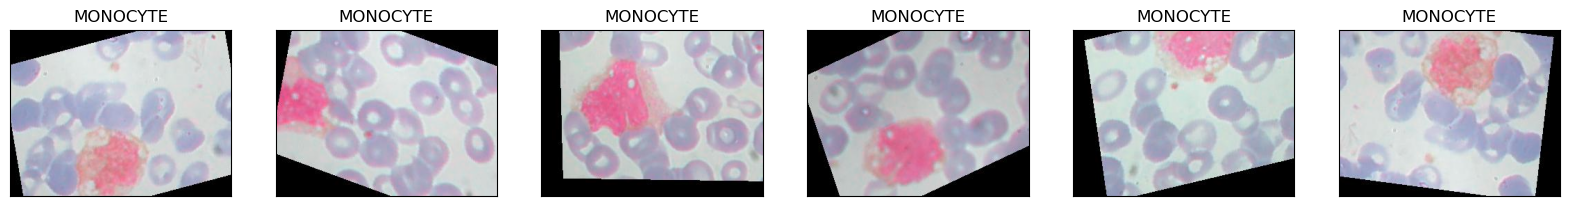

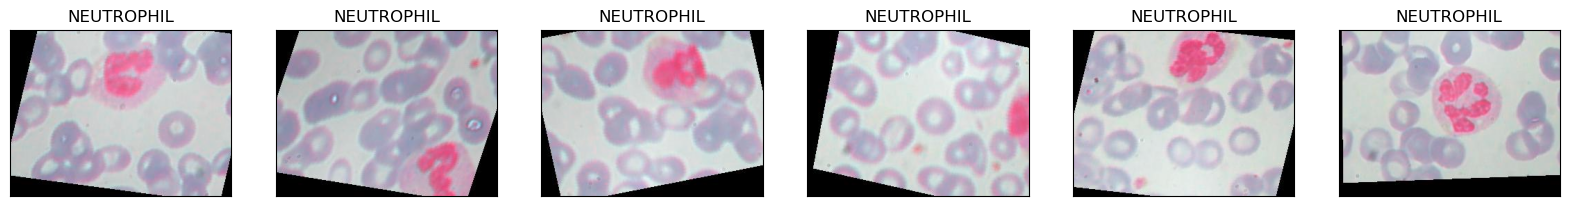

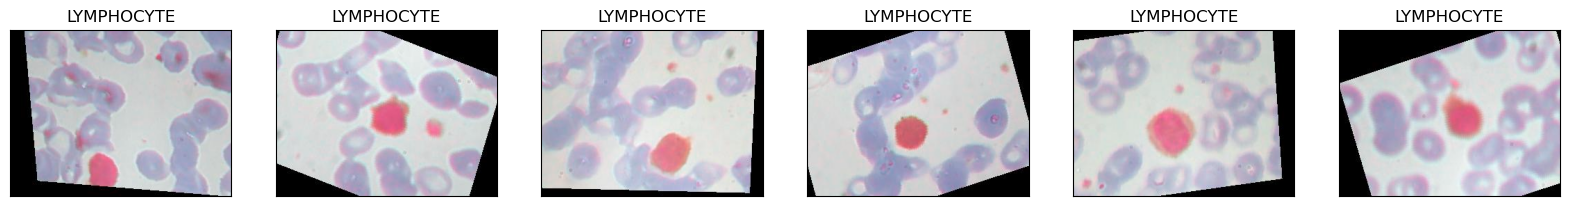

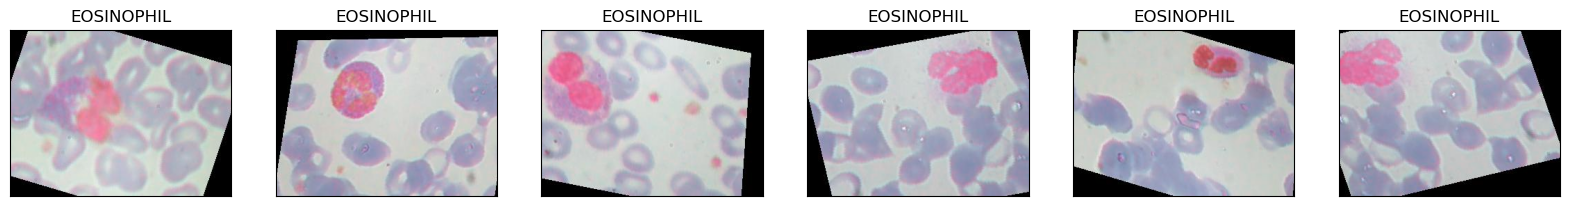

In [68]:
for i in os.listdir(Train_path):
    total_imgs = os.listdir(os.path.join(Train_path, i))
    sample_imgs = random.sample(total_imgs, 6)
    fig, axes = plt.subplots(1,6, figsize=(20,3), subplot_kw=dict(xticks=[], yticks=[]))
    for k, ax in enumerate(axes.flat):
        ax.imshow(cv2.imread(os.path.join(Train_path,i,sample_imgs[k])))
        ax.set_title(i)

## build the model

In [71]:
train_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'
val_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST'
test_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST_SIMPLE'

In [72]:
for i in os.listdir(train_dir):
    print(f'the size of class {i} is {len(os.listdir(os.path.join(train_dir, i)))} in the Train dataset')

the size of class MONOCYTE is 2478 in the Train dataset
the size of class NEUTROPHIL is 2499 in the Train dataset
the size of class LYMPHOCYTE is 2483 in the Train dataset
the size of class EOSINOPHIL is 2497 in the Train dataset


In [73]:
for i in os.listdir(val_dir):
    print(f'the size of class {i} is {len(os.listdir(os.path.join(val_dir, i)))} in the Train dataset')

the size of class MONOCYTE is 620 in the Train dataset
the size of class NEUTROPHIL is 624 in the Train dataset
the size of class LYMPHOCYTE is 620 in the Train dataset
the size of class EOSINOPHIL is 623 in the Train dataset


In [74]:
for i in os.listdir(test_dir):
    print(f'the size of class {i} is {len(os.listdir(os.path.join(test_dir, i)))} in the Train dataset')

the size of class MONOCYTE is 4 in the Train dataset
the size of class NEUTROPHIL is 48 in the Train dataset
the size of class LYMPHOCYTE is 6 in the Train dataset
the size of class EOSINOPHIL is 13 in the Train dataset


In [75]:
train_generator = ImageDataGenerator(rescale=1.0 / 255)
                                    #horizontal_flip=True, 
                                    #zoom_range=0.1, 
                                    #shear_range=0.2, 
                                    #width_shift_range=0.1,
                                    #height_shift_range=0.1, 
                                    #rotation_range=4, 
                                    #vertical_flip=False

val_generator = ImageDataGenerator(rescale=1.0 / 255)

test_generator = ImageDataGenerator(rescale=1.0 / 255)

In [76]:
train_data = train_generator.flow_from_directory(train_dir,
                                                    class_mode = 'categorical',
                                                    target_size = (48,48),
                                                    batch_size = 32,
                                                    shuffle = True)

val_data = val_generator.flow_from_directory(val_dir,
                                                class_mode = 'categorical',
                                                target_size = (48,48),
                                                batch_size = 32,
                                                shuffle = False)

test_data = val_generator.flow_from_directory(test_dir,
                                                class_mode = 'categorical',
                                                target_size = (48,48),
                                                batch_size = 32,
                                                shuffle = False)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


In [77]:
model = Sequential()

model.add(Conv2D(filters=64, kernel_size=3, padding='same', input_shape=(48,48,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', input_shape=(48,48,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))


model.add(Conv2D(filters=512, kernel_size=3, padding='same', input_shape=(48,48,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=512, kernel_size=3, padding='same', input_shape=(48,48,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_12 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 24, 24, 128)      

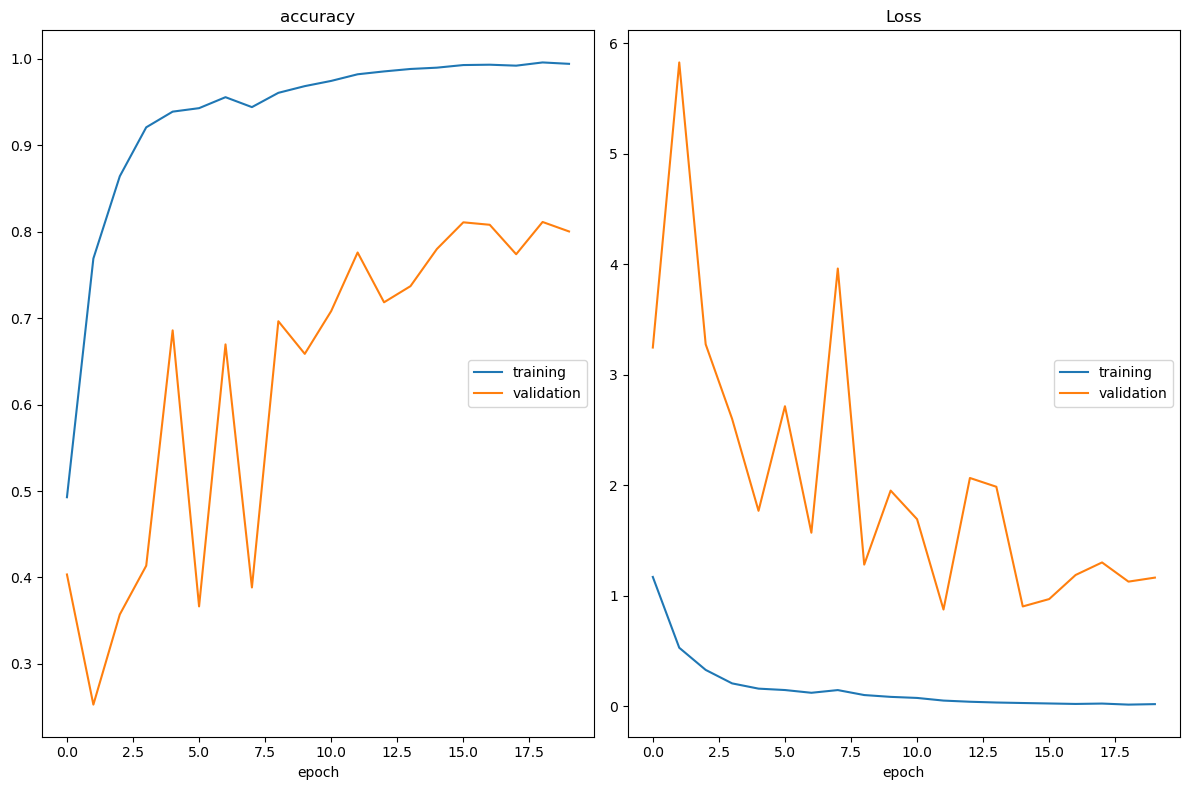

accuracy
	training         	 (min:    0.493, max:    0.996, cur:    0.994)
	validation       	 (min:    0.253, max:    0.811, cur:    0.800)
Loss
	training         	 (min:    0.014, max:    1.169, cur:    0.018)
	validation       	 (min:    0.874, max:    5.825, cur:    1.163)

Epoch 20: saving model to model_weights.h5
311/311 [==============================] - 156s 500ms/step - loss: 0.0182 - accuracy: 0.9943 - val_loss: 1.1632 - val_accuracy: 0.8003 - lr: 3.1250e-05


In [78]:
epochs = 20
steps_per_epoch = train_data.n//32
validation_steps = val_data.n//32

checkpoint = ModelCheckpoint('model_weights.h5', monitor='val_accuracy',save_weight_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.00001, mode='auto')
callbacks=[PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(x=train_data, 
                    steps_per_epoch = steps_per_epoch,
                    epochs=epochs,
                    validation_data=val_data, 
                    validation_steps=validation_steps,
                    callbacks=callbacks)

### test the model

In [79]:
model.evaluate(test_data)

3/3 [==============================] - 0s 65ms/step - loss: 0.8661 - accuracy: 0.8310


[0.8661354780197144, 0.8309859037399292]

In [80]:
pred = model.predict(test_data, test_data.n//32)

3/3 [==============================] - 0s 63ms/step


<Axes: >

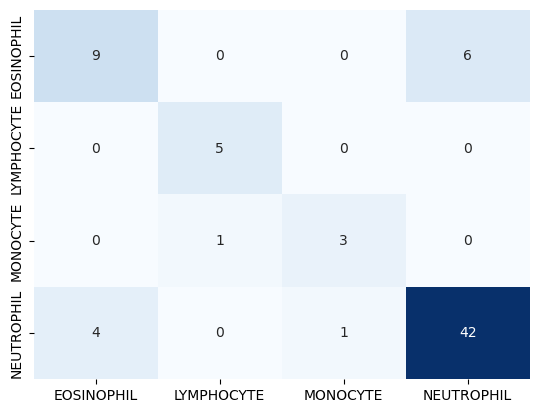

In [96]:
sns.heatmap(confusion_matrix(np.argmax(pred, axis=1), test_data.classes), annot=True, cmap='Blues', cbar=False, xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())

In [99]:
print(classification_report(np.argmax(pred, axis=1), test_data.classes))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.83      1.00      0.91         5
           2       0.75      0.75      0.75         4
           3       0.88      0.89      0.88        47

    accuracy                           0.83        71
   macro avg       0.79      0.81      0.80        71
weighted avg       0.83      0.83      0.83        71

